In [1]:
using Distributions
using StatsPlots
using SymPy
using Memoization

In [2]:
# 帰無仮説下での最尤法で得られる予測分布の期待値

function expectval(a, b, c, d)
    N = a + b + c + d
    A = (a + b)*(a + c)/N
    B = (a + b)*(b + d)/N
    C = (c + d)*(a + c)/N
    D = (c + d)*(b + d)/N
    A, B, C, D
end

@vars a b c d
expectval(a, b, c, d) |> collect

4-element Vector{Sym}:
 (a + b)*(a + c)/(a + b + c + d)
 (a + b)*(b + d)/(a + b + c + d)
 (a + c)*(c + d)/(a + b + c + d)
 (b + d)*(c + d)/(a + b + c + d)

In [3]:
# ピアソンのχ²統計量

safediv(x, y) = iszero(x) ? x : x/y

function chisqstat(a, b, c, d)
    A, B, C, D = expectval(a, b, c, d)
    safediv((a - A)^2, A) + safediv((b - B)^2, B) + safediv((c - C)^2, C) + safediv((d - D)^2, D)
end

@vars a b c d
chisqstat(a, b, c, d) |> factor

             2                 
  (a*d - b*c) *(a + b + c + d) 
-------------------------------
(a + b)*(a + c)*(b + d)*(c + d)

In [4]:
# ピアソンのχ²統計量の実装し直し

@memoize function chisqstat(a, b, c, d)
    safediv((a*d - b*c)^2 * (a + b + c + d), (a + b)*(c + d)*(a + c)*(b + d))
end
chisqstat(A) = chisqstat(A...)

@vars a b c d
chisqstat(a, b, c, d)

             2                 
  (a*d - b*c) *(a + b + c + d) 
-------------------------------
(a + b)*(a + c)*(b + d)*(c + d)

In [5]:
# 対数尤度比のG統計量

xlogy(x, y) = iszero(x) ? x : x*log(y)

@memoize function gstat(a, b, c, d)
    A, B, C, D = expectval(a, b, c, d)
    xlogy(a, a) - xlogy(a, A) +
    xlogy(b, b) - xlogy(b, B) +
    xlogy(c, c) - xlogy(c, C) +
    xlogy(d, d) - xlogy(d, D)
end
gstat(A) = gstat(A...)

@vars a b c d
gstat(a, b, c, d)

                /(a + b)*(a + c)\                   /(a + b)*(b + d)\         
a*log(a) - a*log|---------------| + b*log(b) - b*log|---------------| + c*log(
                \ a + b + c + d /                   \ a + b + c + d /         

          /(a + c)*(c + d)\                   /(b + d)*(c + d)\
c) - c*log|---------------| + d*log(d) - d*log|---------------|
          \ a + b + c + d /                   \ a + b + c + d /

In [6]:
# multを独立性の帰無仮説を満たす四項分布とする

n = 100
p = 0.3
q = 0.4

mult = Multinomial(n, vec([p, 1-p]*[q, 1-q]'))

Multinomial{Float64, Vector{Float64}}(n=100, p=[0.12, 0.27999999999999997, 0.18, 0.42])

In [7]:
# 上で与えた分布multに従う乱数を沢山生成する。

L = 10^5
X = [rand(mult) for _ in 1:L]
first(X, 5)

5-element Vector{Vector{Int64}}:
 [6, 26, 22, 46]
 [12, 31, 21, 36]
 [12, 26, 19, 43]
 [18, 39, 11, 32]
 [15, 27, 15, 43]

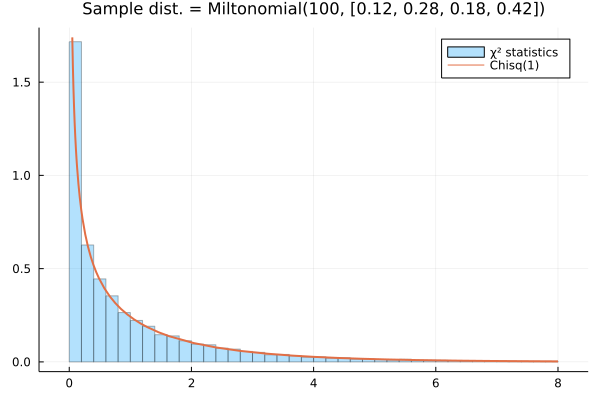

In [8]:
# ピアソンのχ²統計量の分布

C = chisqstat.(X)
histogram(C; norm=true, alpha=0.3, bin=0:0.2:8, label="χ² statistics")
plot!(Chisq(1), 0.05, 8; label="Chisq(1)", lw=2)
title!("Sample dist. = Miltonomial($n, $(round.(probs(mult); digits=3)))"; titlefontsize=11)

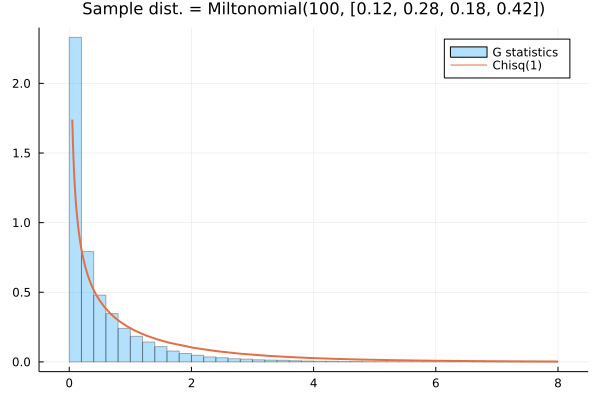

In [9]:
# 対数尤度比のG統計量の分布

G = gstat.(X)
histogram(G; norm=true, alpha=0.3, bin=0:0.2:8, label="G statistics")
plot!(Chisq(1), 0.05, 8; label="Chisq(1)", lw=2)
title!("Sample dist. = Miltonomial($n, $(round.(probs(mult); digits=3)))"; titlefontsize=11)